<a href="https://colab.research.google.com/github/Gabril0/CNN/blob/main/Attention_UNET_N/DataAug_W/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Summary of the model studied
The model studied focus mainly in providing an U-NET with a good and robust data augmentation to avoid pitfalls and enhance the learning capabilities.

In [8]:
#downloading the dataset
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9bsc36jyrt-1.zip

--2024-03-28 21:05:06--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/9bsc36jyrt-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.89.208, 3.5.68.103, 52.92.33.50, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.89.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1081025712 (1.0G) [application/zip]
Saving to: ‘9bsc36jyrt-1.zip’

9bsc36jyrt-1.zip    100%[===================>]   1.01G  76.4MB/s    in 12s     

2024-03-28 21:05:18 (88.1 MB/s) - ‘9bsc36jyrt-1.zip’ saved [1081025712/1081025712]



In [9]:
#imports
import os
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose,Cropping2D, Concatenate, Activation, BatchNormalization
from keras import Model
from keras.regularizers import l2

In [10]:
#unzipping
!unzip /content/9bsc36jyrt-1.zip
!rm -r "/content/9bsc36jyrt-1.zip"
clear_output()

In [11]:
#getting path references
#training used only the roi folders

testing_folder1 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009009/01-roi"
testing_folder2 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009010x1000902/01-roi"
testing_folder3 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009011/01-roi"
testing_folder4 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009014/01-roi"
testing_folder5 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009016x1000903/01-roi"
testing_folder6 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/testing/tumor/patch/640x640/1009023/01-roi"

training_folder1 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009009/01-roi"
training_folder2 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009010x1000902/01-roi"
training_folder3 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009011/01-roi"
training_folder4 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009014/01-roi"
training_folder5 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009016x1000903/01-roi"
training_folder6 = "/content/H&E-stained oral squamous cell carcinoma histological images dataset/training/tumor/patch/640x640/1009023/01-roi"

training_folders = [training_folder1, training_folder2, training_folder3, training_folder4, training_folder5, training_folder6]
#the mask folders will be added dinamically
testing_folders = [testing_folder1, testing_folder2, testing_folder3, testing_folder4, testing_folder5, testing_folder6]

training_path = []
mask_path = []
test_path = []
test_mask_path = []


def append_paths(folder, pathList, complementaryPath):
    full_path = os.path.join(folder, complementaryPath)
    if os.path.isdir(full_path):
        for file in os.listdir(full_path):
            if file.endswith(".png"):
                pathList.append(os.path.join(full_path, file))
            else:
                print("error in file " + file)
    else:
        print("error: " + full_path + " could not be found")

for folder in training_folders: #appending the paths for the original images and respective masks
  append_paths(folder,training_path,"01-original")
  append_paths(folder,mask_path,"02-mask")

for folder in testing_folders: #appending the paths for the test images
  append_paths(folder,test_path,"01-original")
  append_paths(folder,test_mask_path,"02-mask")


In [12]:
#transforming into numpy array

width = 192
height = 192

def path_to_array(path, numpyArray):
  for file in path:
    image = plt.imread(file)
    image_array = np.array(image)
    resized_image = cv2.resize(image_array, (width,height))
    numpyArray.append(resized_image)

training_array = []
mask_array = []
test_array = []
test_mask_array = []

path_to_array(training_path, training_array)
path_to_array(mask_path, mask_array)
path_to_array(test_path, test_array)
path_to_array(test_mask_path, test_mask_array)


In [13]:
print(len(training_array))

361


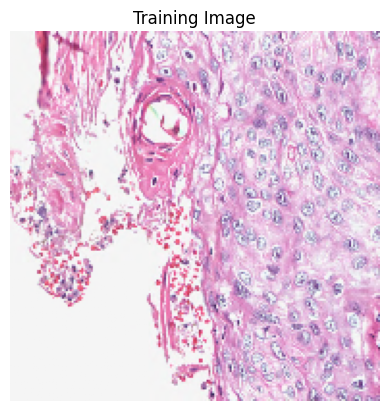

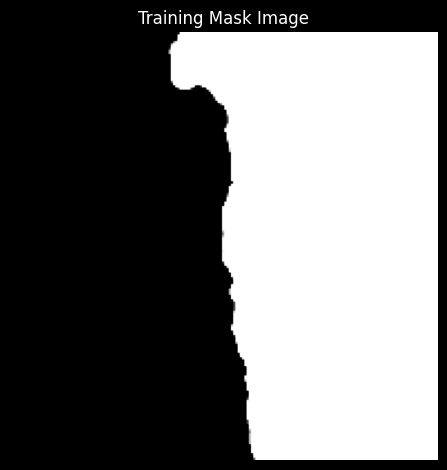

In [14]:
#showing an image
plt.imshow(training_array[5])
plt.title('Training Image')
plt.axis('off')

plt.figure(facecolor='black')
plt.imshow(mask_array[5])
plt.title('Training Mask Image',color="white")
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
#data augmentation
#do data augmentation horizontal flip, vertical flip, rotation, transpose, grid distortion,
#optical distortion, color transfer, inpainting
#def preprocess_mask(mask):
#    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#    mask_normalized = mask_gray / 255.0
#    mask_expanded = np.expand_dims(mask_normalized, axis=-1)
#    return mask_expanded
from PIL import Image

def preprocess_mask(mask):
    if mask.dtype == np.float32:
        mask = (mask * 255).astype(np.uint8)

    if mask.shape[-1] != 1:
        mask = np.array(Image.fromarray(mask).convert('L'))

    threshold = 127
    mask = (mask > threshold).astype(np.uint8) * 255

    mask = mask / 255.0

    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)

    return mask

def flip_horizontal(image_array, mask_array):
    aug_images = []
    aug_masks = []
    for image, mask in zip(image_array, mask_array):
        aug_image = np.flip(image, axis=1)
        aug_mask = np.flip(mask, axis=1)

        aug_images.append(aug_image)
        aug_masks.append(aug_mask)

    return aug_images, aug_masks

def flip_vertical(image_array, mask_array):
    aug_images = []
    aug_masks = []
    for image, mask in zip(image_array, mask_array):
        aug_image = np.flip(image, axis=0)
        aug_mask = np.flip(mask, axis=0)

        aug_images.append(aug_image)
        aug_masks.append(aug_mask)

    return aug_images, aug_masks

def random_rotation(image_array, mask_array):
    aug_images = []
    aug_masks = []
    for image, mask in zip(image_array, mask_array):
        angle = random.uniform(0, 360)

        height, width = image.shape[:2]

        rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

        rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
        rotated_mask = cv2.warpAffine(mask, rotation_matrix, (width, height))

        aug_images.append(rotated_image)
        aug_masks.append(rotated_mask)

    return aug_images, aug_masks

def grid_distort(image_array, mask_array, rows=10, cols=10):
    aug_images = []
    aug_masks = []
    for image, mask in zip(image_array, mask_array):
        distort_grid = np.indices(image.shape[:2], dtype=np.float32)
        distort_grid += np.random.normal(size=distort_grid.shape) * 10

        distort_grid[0] = np.clip(distort_grid[0], 0, image.shape[0] - 1)
        distort_grid[1] = np.clip(distort_grid[1], 0, image.shape[1] - 1)

        map_x = distort_grid[1]
        map_y = distort_grid[0]

        distorted_image = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
        distorted_mask = cv2.remap(mask, map_x, map_y, cv2.INTER_LINEAR)

        aug_images.append(distorted_image)
        aug_masks.append(distorted_mask)

    return aug_images, aug_masks

augmented_images, augmented_masks = training_array, mask_array
#augmented_images, augmented_masks = flip_horizontal(training_array, mask_array)
#augmented_images.extend(flip_vertical(training_array, mask_array)[0])
#augmented_masks.extend(flip_vertical(training_array, mask_array)[1])
#augmented_images.extend(random_rotation(training_array, mask_array)[0])
#augmented_masks.extend(random_rotation(training_array, mask_array)[1])
#augmented_images.extend(grid_distort(training_array, mask_array)[0])
#augmented_masks.extend(grid_distort(training_array, mask_array)[1])

preprocessed_augmented_images = augmented_images
preprocessed_test_array = test_array

preprocessed_test_masks = [preprocess_mask(mask) for mask in test_mask_array]
preprocessed_augmented_masks = [preprocess_mask(mask) for mask in augmented_masks]


In [16]:
# horizontal/vertical flip, rotation, elastictransformation,  grid  distortion  and  optical  distortion.

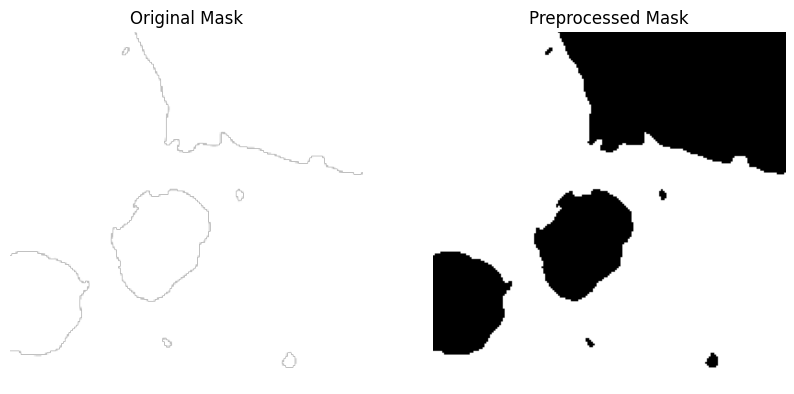

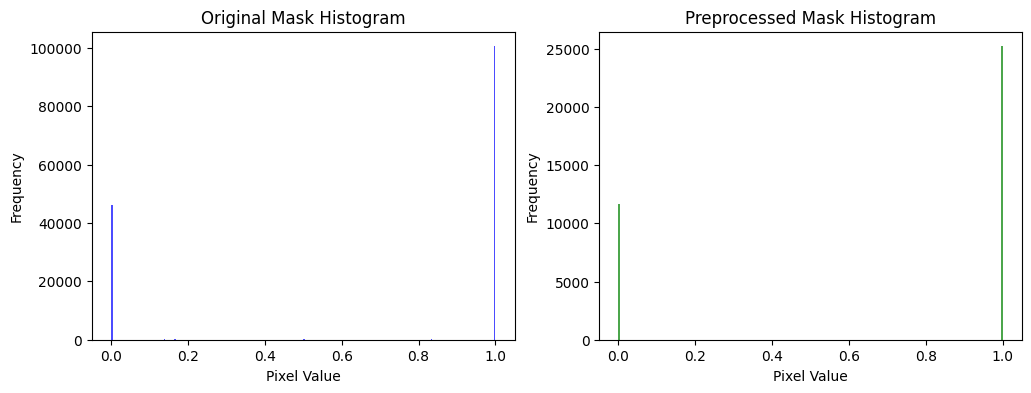

Preprocessed mask shape: (192, 192, 1)
Preprocessed mask data type: float64
Preprocessed mask min value: 0.0
Preprocessed mask max value: 1.0
Preprocessed mask mean value: 0.6839735243055556
Preprocessed mask std deviation: 0.46492337256218164


In [17]:
index_to_check = 8
original_mask = test_mask_array[index_to_check]
preprocessed_mask = preprocessed_test_masks[index_to_check]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_mask)
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_mask.squeeze(), cmap='gray')
plt.title('Preprocessed Mask')
plt.axis('off')

plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(original_mask.ravel(), bins=256, color='blue', alpha=0.7)
plt.title('Original Mask Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(preprocessed_mask.ravel(), bins=256, color='green', alpha=0.7)
plt.title('Preprocessed Mask Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.show()

print(f"Preprocessed mask shape: {preprocessed_mask.shape}")
print(f"Preprocessed mask data type: {preprocessed_mask.dtype}")
print(f"Preprocessed mask min value: {np.min(preprocessed_mask)}")
print(f"Preprocessed mask max value: {np.max(preprocessed_mask)}")
print(f"Preprocessed mask mean value: {np.mean(preprocessed_mask)}")
print(f"Preprocessed mask std deviation: {np.std(preprocessed_mask)}")

In [18]:
print(len(preprocessed_augmented_images))
print(len(preprocessed_augmented_masks))

361
361


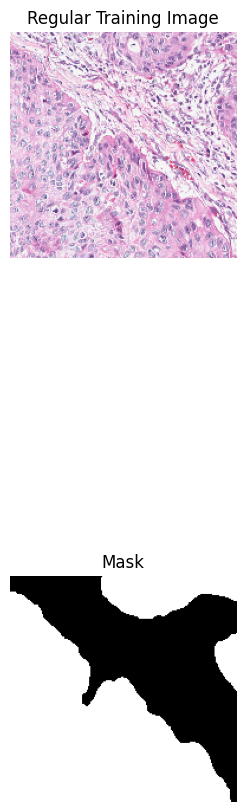

In [19]:
#showing data aug results
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(3, 2, 1)
plt.imshow(preprocessed_augmented_images[1])
plt.title('Regular Training Image')
plt.axis('off')

#plt.subplot(3, 2, 2)
#plt.imshow(preprocessed_augmented_images[362])
#plt.title('HFlip Training Image')
#plt.axis('off')

#plt.subplot(3, 2, 3)
#plt.imshow(preprocessed_augmented_images[723])
#plt.title('Random Rotation Training Image')
#plt.axis('off')

#plt.subplot(3, 2, 4)
#plt.imshow(preprocessed_augmented_images[723])
#plt.title('GridDistortion Training Image')
#plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(preprocessed_augmented_masks[1],cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

In [20]:
#constructing the UNET functions

def conv_block(inputs,filters):
  #two conv layers with batch normalization and relu, this makes features more apparent as the tiny weight get smaller and big ones grow
  conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)
  conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(conv)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)
  return conv

def attention_gate(input_tensor, skip_tensor, filters):
  #relu
  attn = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(input_tensor)
  attn = BatchNormalization()(attn)
  attn = Activation('relu')(attn)

  #sigmoid
  attn = Conv2D(filters, kernel_size=(1, 1), strides=(2, 2), padding='same')(attn)
  attn = BatchNormalization()(attn)
  attn = Activation('sigmoid')(attn)

  #resampler
  attn = UpSampling2D(size=(2, 2))(attn)
  attn = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(attn)

  #multiplication with the skip_tensor layer
  multiplied = tf.multiply(skip_tensor, attn)

  concatenated = Concatenate()([input_tensor, multiplied])
  return concatenated

def unet_build(input_shape):
  inputs = Input(input_shape)

  #downsampling
  conv1 = conv_block(inputs, 64)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = conv_block(pool1, 128)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = conv_block(pool2, 256)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = conv_block(pool3, 512)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  #bridge
  conv5 = conv_block(pool4, 1024)

  #upsampling
  up6 = UpSampling2D(size=(2, 2))(conv5)
  up6 = attention_gate(up6, conv4, 512)
  conv6 = conv_block(up6, 512)

  up7 = UpSampling2D(size=(2, 2))(conv6)
  up7 = attention_gate(up7, conv3, 256)
  conv7 = conv_block(up7, 256)

  up8 = UpSampling2D(size=(2, 2))(conv7)
  up8 = attention_gate(up8, conv2, 128)
  conv8 = conv_block(up8, 128)

  up9 = UpSampling2D(size=(2, 2))(conv8)
  up9 = attention_gate(up9, conv1, 64)
  conv9 = conv_block(up9, 64)

  outputs = Conv2D(1, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid')(conv9)

  model = Model(inputs=inputs, outputs=outputs)
  return model

In [21]:
#creation of the network
input_shape = (width, height, 3)
model = unet_build(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 192, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 192, 192, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 192, 192, 64)         0         ['batch_normalization[0][0

In [22]:
preprocessed_augmented_images = np.array(preprocessed_augmented_images)
preprocessed_augmented_masks = np.array(preprocessed_augmented_masks)
preprocessed_test_array = np.array(preprocessed_test_array)
preprocessed_test_masks= np.array(preprocessed_test_masks)

In [23]:
print("Shape of augmented_images:", preprocessed_augmented_images.shape)
print("Shape of augmented_masks:", preprocessed_augmented_masks.shape)
print("Shape of test_array:", preprocessed_test_array.shape)
print("Shape of test_mask_array:", preprocessed_test_masks.shape)

Shape of augmented_images: (361, 192, 192, 3)
Shape of augmented_masks: (361, 192, 192, 1)
Shape of test_array: (61, 192, 192, 3)
Shape of test_mask_array: (61, 192, 192, 1)


In [24]:
#augmented_images_with_channel = np.concatenate([augmented_images, np.ones_like(augmented_images[..., :1])], axis=-1)
#test_array_with_channel = np.concatenate([test_array, np.ones_like(test_array[..., :1])], axis=-1)

#print("Shape of augmented_images after adding channel:", augmented_images_with_channel.shape)
#print("Shape of test_array after adding channel:", test_array_with_channel.shape)


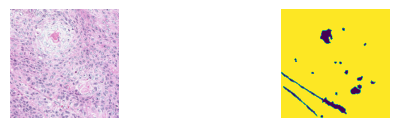

In [25]:
plt.subplot(3, 2, 1)
plt.imshow(preprocessed_test_array[1])
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(preprocessed_test_masks[1])
plt.axis('off')

plt.show()

In [26]:
#training
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


#test_images = np.squeeze(test_images)
#test_masks = np.squeeze(test_masks)
#print("Updated Test images shape:", test_images.shape)
#print("Updated Test masks shape:", test_masks.shape)



history = model.fit(preprocessed_augmented_images,
                    preprocessed_augmented_masks,
                    validation_data=(preprocessed_test_array, preprocessed_test_masks),
                    epochs=50,
                    batch_size=8)

Epoch 1/50
46/46 [==============================] - 77s 828ms/step - loss: 0.5599 - accuracy: 0.7067 - val_loss: 94.3221 - val_accuracy: 0.5618
Epoch 2/50
46/46 [==============================] - 19s 416ms/step - loss: 0.4390 - accuracy: 0.8021 - val_loss: 4.2686 - val_accuracy: 0.5543
Epoch 3/50
46/46 [==============================] - 19s 419ms/step - loss: 0.4794 - accuracy: 0.7712 - val_loss: 1.3707 - val_accuracy: 0.4422
Epoch 4/50
46/46 [==============================] - 19s 420ms/step - loss: 0.4167 - accuracy: 0.8116 - val_loss: 1.7731 - val_accuracy: 0.4440
Epoch 5/50
46/46 [==============================] - 20s 425ms/step - loss: 0.4047 - accuracy: 0.8187 - val_loss: 3.0062 - val_accuracy: 0.4379
Epoch 6/50
46/46 [==============================] - 20s 432ms/step - loss: 0.4103 - accuracy: 0.8142 - val_loss: 1.6034 - val_accuracy: 0.5800
Epoch 7/50
46/46 [==============================] - 20s 429ms/step - loss: 0.4451 - accuracy: 0.7901 - val_loss: 1.9621 - val_accuracy: 0.450

In [27]:
#evaluate the model
loss, accuracy = model.evaluate(preprocessed_test_array, preprocessed_test_masks)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2/2 [==============================] - 35s 17s/step - loss: 0.3995 - accuracy: 0.7880
Test Loss: 0.39952561259269714
Test Accuracy: 0.7880241274833679


1/1 [==============================] - 1s 540ms/step


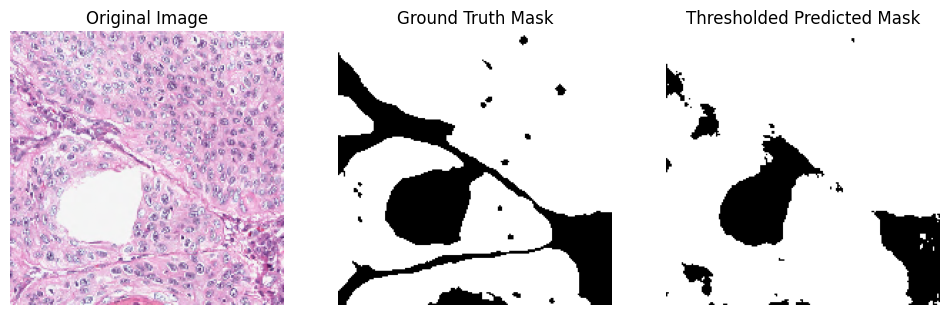

In [28]:
#testing

image_index = 6

test_image = preprocessed_test_array[image_index]
test_mask = preprocessed_test_masks[image_index]

test_image = np.expand_dims(test_image, axis=0)

predicted_mask = model.predict(test_image)

threshold_value = 0.2
thresholded_mask = (predicted_mask > threshold_value).astype(np.uint8)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(test_image.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(test_mask.squeeze(), cmap='gray')
plt.axis('off')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(thresholded_mask.squeeze(), cmap='gray')  # Use thresholded mask here
plt.axis('off')
plt.title('Thresholded Predicted Mask')

plt.show()


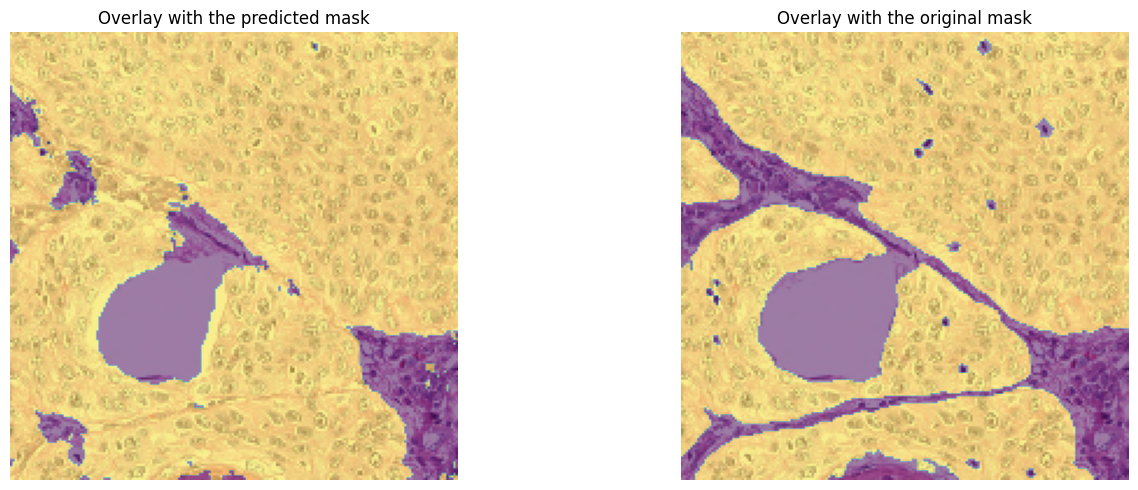

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(test_image.squeeze())
axs[0].imshow(thresholded_mask.squeeze(), alpha=0.5)
axs[0].axis('off')
axs[0].set_title('Overlay with the predicted mask')

axs[1].imshow(test_image.squeeze())
axs[1].imshow(test_mask.squeeze(), alpha=0.5)
axs[1].axis('off')
axs[1].set_title('Overlay with the original mask')

plt.tight_layout()

plt.show()

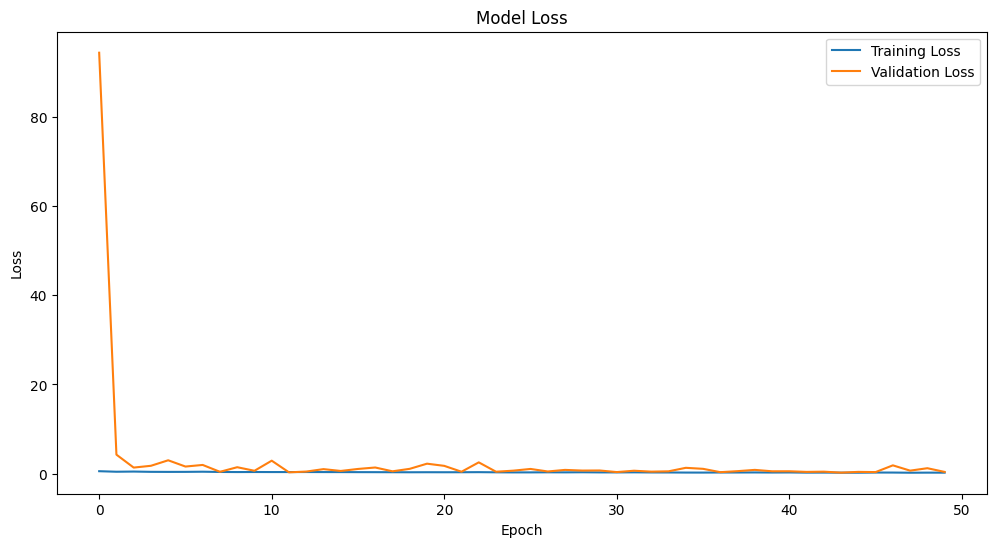

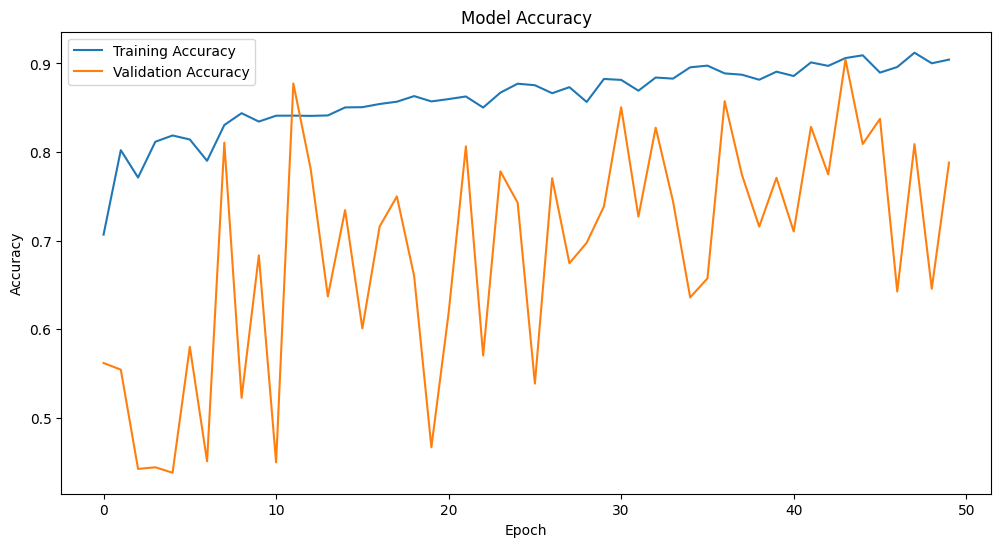

In [30]:
#analytics

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()